In [1]:
import requests
import xlrd
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import networkx as nx
import os
from math import radians, cos, sin, sqrt, atan2
from dotenv import load_dotenv
from shapely import wkt
from shapely.geometry import Point


pd.set_option('display.max_rows', None)
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'

# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

In [2]:
%run get_bus_info_function.ipynb

## Reading in data

In [3]:
#reading in data frames
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)
train_stations = pd.read_excel("../datasets/Train_Stations.xls")
geospatial_train_path = "../datasets/geospatial_layer/TrainStation_Jul2024"
geospatial_train_gdf = gpd.read_file(geospatial_train_path)

In [4]:
train_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Station_Code  211 non-null    object
 1   MRT_Station   211 non-null    object
 2   MRT_Line      211 non-null    object
dtypes: object(3)
memory usage: 5.1+ KB


In [5]:
train_stations.head()

,Station_Code,MRT_Station,MRT_Line
0,NS1,Jurong East,North-South Line
1,NS2,Bukit Batok,North-South Line
2,NS3,Bukit Gombak,North-South Line
3,NS4,Choa Chu Kang,North-South Line
4,NS5,Yew Tee,North-South Line


In [6]:
bus_routes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25544 entries, 0 to 25543
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ServiceNo     25544 non-null  object 
 1   Operator      25544 non-null  object 
 2   Direction     25544 non-null  int64  
 3   StopSequence  25544 non-null  int64  
 4   BusStopCode   25544 non-null  object 
 5   Distance      25544 non-null  float64
 6   WD_FirstBus   25544 non-null  object 
 7   WD_LastBus    25544 non-null  object 
 8   SAT_FirstBus  25544 non-null  object 
 9   SAT_LastBus   25544 non-null  object 
 10  SUN_FirstBus  25544 non-null  object 
 11  SUN_LastBus   25544 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [7]:
bus_routes_df.head() 

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus
0,10,SBST,1,1,75009,0.0,0500,2300,0500,2300,0500,2300
1,10,SBST,1,2,76059,0.6,0502,2302,0502,2302,0502,2302
2,10,SBST,1,3,76069,1.1,0504,2304,0504,2304,0503,2304
3,10,SBST,1,4,96289,2.3,0508,2308,0508,2309,0507,2308
4,10,SBST,1,5,96109,2.7,0509,2310,0509,2311,0508,2309


In [8]:
geospatial_train_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TYP_CD      230 non-null    int64   
 1   STN_NAM     0 non-null      object  
 2   ATTACHEMEN  51 non-null     object  
 3   TYP_CD_DES  230 non-null    object  
 4   STN_NAM_DE  230 non-null    object  
 5   geometry    230 non-null    geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 10.9+ KB


In [9]:
geospatial_train_gdf.head()

,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
0,0,None,None,MRT,GALI BATU DEPOT,"POLYGON ((19210.615 41858.041, 19223.517 41756..."
1,0,None,None,MRT,HILLVIEW MRT STATION,"POLYGON ((20650.333 38282.331, 20654.770 38298..."
2,0,None,None,MRT,BEAUTY WORLD MRT STATION,"POLYGON ((21594.717 35882.935, 21584.857 35880..."
3,0,None,None,MRT,HUME MRT STATION,"POLYGON ((20807.997 37457.716, 20815.376 37460..."
4,0,None,None,MRT,BUKIT PANJANG MRT STATION,"POLYGON ((19996.270 40187.205, 20028.770 40127..."


## Data Pre-Processing

### Bus Stop 

In [10]:
# Merge bus_routes_df with bus_stops_df to get the lat-long of each bus stop
merged_bus_routes = pd.merge(bus_routes_df, bus_stops_df, on='BusStopCode', how='left')

#Ensure there's no rows with na values for longitude and latitude
print(merged_bus_routes.head())

  ServiceNo Operator  Direction  StopSequence BusStopCode  Distance  \
0        10     SBST          1             1       75009       0.0   
1        10     SBST          1             2       76059       0.6   
2        10     SBST          1             3       76069       1.1   
3        10     SBST          1             4       96289       2.3   
4        10     SBST          1             5       96109       2.7   

  WD_FirstBus WD_LastBus SAT_FirstBus SAT_LastBus SUN_FirstBus SUN_LastBus  \
0        0500       2300         0500        2300         0500        2300   
1        0502       2302         0502        2302         0502        2302   
2        0504       2304         0504        2304         0503        2304   
3        0508       2308         0508        2309         0507        2308   
4        0509       2310         0509        2311         0508        2309   

          RoadName           Description  Latitude   Longitude  
0  Tampines Ctrl 1          Tampines In

### Train Stations

In [11]:
# Step 1: Union the geometries for the same station
unioned_gdf = geospatial_train_gdf.dissolve(by='STN_NAM_DE',aggfunc='first')

# Step 2: Calculate the centroid of the unioned polygon
unioned_gdf['centroid'] = unioned_gdf.centroid

# Optional Step: Replace geometry with centroid point
unioned_gdf['geometry'] = unioned_gdf['centroid']

# Reset index to clean up
unioned_gdf.reset_index(inplace=True)

c:\Users\Gene\anaconda3\envs\DSA4264\Lib\site-packages\geopandas\geodataframe.py:1816: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


In [12]:
unioned_gdf.head()

,STN_NAM_DE,geometry,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,centroid
0,ADMIRALTY MRT STATION,POINT (24400.883 46918.344),0,None,None,MRT,POINT (24400.883 46918.344)
1,ALJUNIED MRT STATION,POINT (33518.605 33189.987),0,None,None,MRT,POINT (33518.605 33189.987)
2,ANG MO KIO MRT STATION,POINT (29813.745 39107.484),0,None,None,MRT,POINT (29813.745 39107.484)
3,BAKAU LRT STATION,POINT (36035.791 41115.238),0,None,None,LRT,POINT (36035.791 41115.238)
4,BANGKIT LRT STATION,POINT (21249.598 40220.704),0,None,None,LRT,POINT (21249.598 40220.704)


In [13]:
# Function to normalize station names in train_stations_df
def normalize_station_name(name):
    return name.strip().upper()  # Ensure names are uppercase for consistent merging

# Apply normalization function to train_stations_df
train_stations['Normalized_Station'] = train_stations['MRT_Station'].apply(normalize_station_name)

# Create a column to append " MRT STATION" or " LRT STATION" based on the MRT_Line
train_stations['Station_MRT_LRT'] = train_stations.apply(
    lambda row: f"{row['Normalized_Station']} MRT STATION" if "LRT" not in row['MRT_Line'] else f"{row['Normalized_Station']} LRT STATION",
    axis=1
)

# Apply normalization to geospatial_train_df
# Strip ' MRT STATION' and ' LRT STATION' and normalize to uppercase
unioned_gdf['Normalized_Station'] = unioned_gdf['STN_NAM_DE'].str.strip().str.upper()

# Perform the merge on 'Station_MRT_LRT' from train_stations and 'Normalized_Station' from unioned_gdf
merged_train_stations = train_stations.merge(
    unioned_gdf,
    how='left',
    left_on='Station_MRT_LRT',
    right_on='Normalized_Station'
)

# Keeping necessary columns
columns_to_keep = ['Station_Code', 'MRT_Station', 'MRT_Line', 'TYP_CD_DES', 'geometry']
merged_train_stations = merged_train_stations[columns_to_keep]

# Check the resulting column names and sample data
print(merged_train_stations.head())


  Station_Code    MRT_Station           MRT_Line TYP_CD_DES  \
0          NS1    Jurong East  North-South Line         MRT   
1          NS2    Bukit Batok  North-South Line         MRT   
2          NS3   Bukit Gombak  North-South Line         MRT   
3          NS4  Choa Chu Kang  North-South Line         MRT   
4          NS5        Yew Tee  North-South Line         MRT   

                      geometry  
0  POINT (17866.487 35045.184)  
1  POINT (18676.448 36790.872)  
2  POINT (18940.178 37860.706)  
3  POINT (18101.056 40790.989)  
4  POINT (18438.643 42159.628)  


In [14]:
#  Convert Pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_train_stations, geometry='geometry')

#  Reproject the GeoDataFrame to EPSG:4326 (WGS 84 - latitude/longitude)
gdf_4326 = gdf.to_crs(epsg=4326)

# Extract Longitude and Latitude from the reprojected geometries
gdf_4326['Longitude'] = gdf_4326.geometry.x
gdf_4326['Latitude'] = gdf_4326.geometry.y

#  Convert back to a Pandas DataFrame (if you don't need the geometry anymore)
merged_train_stations = pd.DataFrame(gdf_4326)

# Removing redundant columns
columns_to_keep = ['Station_Code', 'MRT_Station', 'MRT_Line', 'Longitude', 'Latitude']
merged_train_stations = merged_train_stations[columns_to_keep]
print(merged_train_stations.head())


  Station_Code    MRT_Station           MRT_Line   Longitude  Latitude
0          NS1    Jurong East  North-South Line   103.742263  1.333209
1          NS2    Bukit Batok  North-South Line   103.749541  1.348997
2          NS3   Bukit Gombak  North-South Line   103.751910  1.358672
3          NS4  Choa Chu Kang  North-South Line   103.744369  1.385172
4          NS5        Yew Tee  North-South Line   103.747402  1.397550


## Overlapping calculation

### Method 1: Haversine Distance

In [15]:
# Defining Haversine function to calculate difference in distance
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of Earth in meters
    r = 6371000
    return c * r  # Distance in meters

In [16]:
def calculate_overlap_percentage(gdf_bus_stops, gdf_train_stations, max_distance=300):
    results = []

    # Group by ServiceNo to process each bus service separately
    grouped = gdf_bus_stops.groupby('ServiceNo')

    # Iterate over each bus service group
    for service_no, bus_stops_service in grouped:
        # Drop duplicate bus stops if any
        bus_stops_service_unique = bus_stops_service.drop_duplicates(subset=['BusStopCode'])

        total_bus_stops = len(bus_stops_service_unique)
        overlapping_stops = 0

        # For each unique bus stop in the service
        for _, bus_stop in bus_stops_service_unique.iterrows():
            bus_lat, bus_lon = bus_stop['Latitude'], bus_stop['Longitude']

            # Check if this bus stop is within 500m of any MRT station
            for _, mrt_station in gdf_train_stations.iterrows():
                mrt_lat, mrt_lon = mrt_station['Latitude'], mrt_station['Longitude']

                # Calculate the haversine distance between bus stop and MRT station
                distance = haversine(bus_lat, bus_lon, mrt_lat, mrt_lon)

                if distance <= max_distance:
                    overlapping_stops += 1
                    break  # No need to check other MRT stations for this stop

        # Calculate the overlap percentage based on the unique bus stops
        overlap_percentage = (overlapping_stops / total_bus_stops) * 100 if total_bus_stops > 0 else 0
        results.append({
            'ServiceNo': service_no,
            'TotalBusStops': total_bus_stops,
            'OverlappingStops': overlapping_stops,
            'OverlapPercentage': overlap_percentage
        })

    # Convert results into a DataFrame
    overlap_df = pd.DataFrame(results)
    return overlap_df


In [17]:
# Calculating overlapping percentage
overlap_results = calculate_overlap_percentage(merged_bus_routes, merged_train_stations)
print(overlap_results)

    ServiceNo  TotalBusStops  OverlappingStops  OverlapPercentage
0          10            146                39          26.712329
1         100            109                40          36.697248
2        100A             13                 3          23.076923
3         101             45                10          22.222222
4         102             59                14          23.728814
5        102A             11                 3          27.272727
6        102B             11                 4          36.363636
7         103             83                 7           8.433735
8         105            112                29          25.892857
9        105B             13                 2          15.384615
10        106             96                42          43.750000
11       106A             12                 2          16.666667
12        107             77                38          49.350649
13       107M             67                30          44.776119
14        

In [18]:
# Filter for bus services with overlap percentage >= x0%
high_overlap_routes = overlap_results[overlap_results['OverlapPercentage'] >= 60]

# Display the filtered results
print(high_overlap_routes)


    ServiceNo  TotalBusStops  OverlappingStops  OverlapPercentage
104      163A             17                11          64.705882
160      196e             35                21          60.000000
244      307T             15                10          66.666667
272       371             11                10          90.909091
274       374             18                14          77.777778
276       381             27                19          70.370370
277       382             25                16          64.000000
279      382G             14                 9          64.285714
280      382W             14                10          71.428571
281       384             13                13         100.000000
290       400             20                14          70.000000
348       654             26                24          92.307692
350       656             35                23          65.714286
357       666             33                27          81.818182
362       

C:\Users\Gene\AppData\Local\Temp\ipykernel_12904\2627258367.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ServiceNo', y='OverlapPercentage', data=overlap_df_sorted, palette='Blues_d')


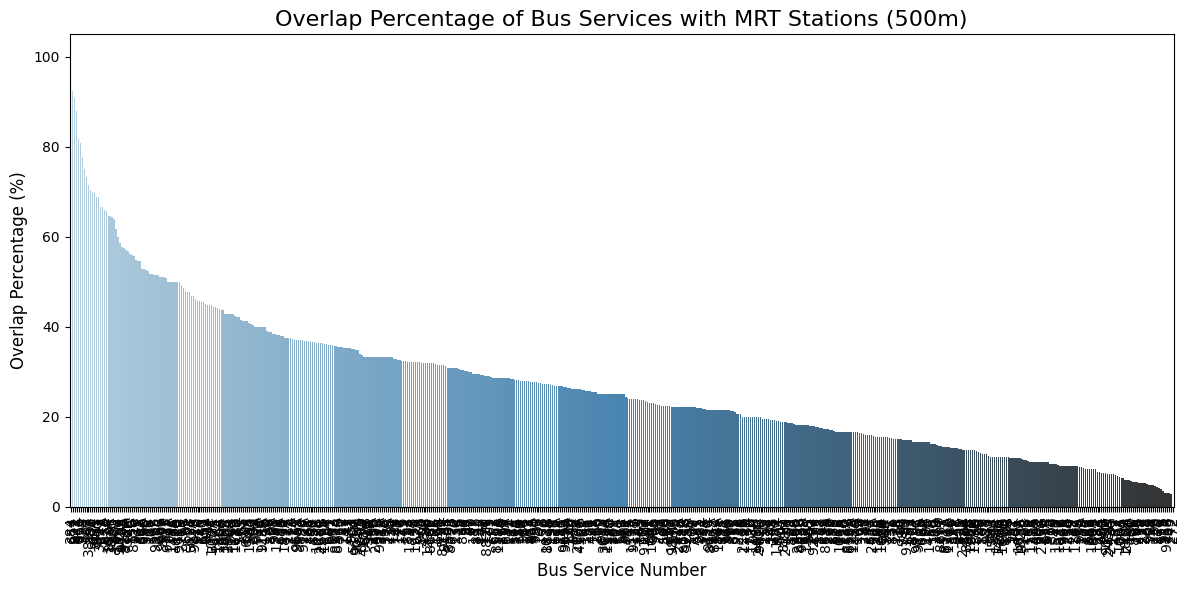

In [19]:
def visualize_overlap_percentage(overlap_df):
    # Sort the data by overlap percentage
    overlap_df_sorted = overlap_df.sort_values(by='OverlapPercentage', ascending=False)

    # Set up the plot
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot
    sns.barplot(x='ServiceNo', y='OverlapPercentage', data=overlap_df_sorted, palette='Blues_d')

    # Customize the plot
    plt.xticks(rotation=90)  # Rotate service numbers for better visibility
    plt.title('Overlap Percentage of Bus Services with MRT Stations (500m)', fontsize=16)
    plt.xlabel('Bus Service Number', fontsize=12)
    plt.ylabel('Overlap Percentage (%)', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Visualize the overlap percentage
visualize_overlap_percentage(overlap_results)


### Method 2: Road Distance

In [20]:
merged_bus_routes_rd = merged_bus_routes.copy()
merged_bus_routes_rd = merged_bus_routes[merged_bus_routes['ServiceNo']=='10']
merged_train_stations_rd = merged_train_stations.copy()

# Step 1: Convert DataFrames to GeoDataFrames for bus stops and train stations
bus_stops_gdf = gpd.GeoDataFrame(
    merged_bus_routes_rd, geometry=gpd.points_from_xy(merged_bus_routes_rd.Longitude, merged_bus_routes_rd.Latitude), crs="EPSG:4326"
)
train_stations_gdf = gpd.GeoDataFrame(
    merged_train_stations_rd, geometry=gpd.points_from_xy(merged_train_stations_rd.Longitude, merged_train_stations_rd.Latitude), crs="EPSG:4326"
)

# Step 2: Project GeoDataFrames to a suitable metric CRS (EPSG:3414 for Singapore)
bus_stops_gdf = bus_stops_gdf.to_crs(epsg=3414)
train_stations_gdf = train_stations_gdf.to_crs(epsg=3414)

# Step 3: Prepare a road network using OSMnx
G = ox.graph_from_place('Singapore', network_type='walk')

# Step 4: Function to calculate road distance using OSMnx
def calculate_road_distance(bus_stop_coords, mrt_coords):
    try:
        orig_node = ox.distance.nearest_nodes(G, bus_stop_coords[1], bus_stop_coords[0])  # lon, lat
        dest_node = ox.distance.nearest_nodes(G, mrt_coords[1], mrt_coords[0])
        road_distance = nx.shortest_path_length(G, orig_node, dest_node, weight='length')  # distance in meters
        return road_distance
    except:
        return None

# Step 5: Create a unique bus stop buffer and track calculated stops
bus_stops_overlap_tracker = {}  # Store results for bus stops
results = []

# Group by ServiceNo to process each bus route separately
for service_no, bus_route_stops in bus_stops_gdf.groupby('ServiceNo'):
    total_bus_stops = 0
    overlapping_stops = 0
    
    # Step 6: Iterate through each unique bus stop
    for _, bus_stop in bus_route_stops.drop_duplicates(subset='BusStopCode').iterrows():
        bus_stop_code = bus_stop['BusStopCode']
        bus_stop_coords = (bus_stop['Latitude'], bus_stop['Longitude'])

        # Skip if the bus stop has already been processed
        if bus_stop_code in bus_stops_overlap_tracker:
            overlapping_stops += bus_stops_overlap_tracker[bus_stop_code]
            continue

        # Create a 1km buffer around the bus stop
        bus_stop_buffer = bus_stop.geometry.buffer(1000)

        # Step 7: Check if any train stations fall within this buffer
        train_stations_in_buffer = train_stations_gdf[train_stations_gdf.intersects(bus_stop_buffer)]

        # Step 8: Calculate road distances between the bus stop and train stations in the buffer
        overlapping = 0
        for _, train_station in train_stations_in_buffer.iterrows():
            train_station_coords = (train_station['Latitude'], train_station['Longitude'])
            road_distance = calculate_road_distance(bus_stop_coords, train_station_coords)

            if road_distance is not None and road_distance <= 300:
                overlapping = 1
                break  # No need to check other train stations for this stop

        # Step 9: Mark this bus stop as processed and store its result
        bus_stops_overlap_tracker[bus_stop_code] = overlapping
        overlapping_stops += overlapping
        total_bus_stops += 1

    # Step 10: Calculate overlap percentage for the route
    overlap_percentage = (overlapping_stops / total_bus_stops) * 100 if total_bus_stops > 0 else 0
    results.append({
        'ServiceNo': service_no,
        'TotalBusStops': total_bus_stops,
        'OverlappingStops': overlapping_stops,
        'OverlapPercentage': overlap_percentage
    })

In [21]:
# Step 11: Convert results to DataFrame and display
overlap_df_rd = pd.DataFrame(results)
print(overlap_df_rd)

  ServiceNo  TotalBusStops  OverlappingStops  OverlapPercentage
0        10            146                22          15.068493
